# Tarea 1

Aspectos formales en Base a la Norma Técnica de Seguridad y Calidad de Servicio 




## 2.a) Límites admisibles operacionales para el estudio 

### Referente Articulo 5-19 (Shunt)

Tensión nominal Barrras

    -Igual o superior a 500 [kV] =  0,97 y 1,03 por unidad  

    -Igual o superior a 200 [kV] e inferior a 500 [kV] =  0,95 y 1,05 por unidad

    - Inferior a 200 [kV] = 0,93 y 1,07 por unidad

### Referente Articulo 5-23 (Estado de alerta)

    -Igual o superior a 500 [kV] = 0,95 y 1,05 por unidad

    -Igual o superior a 200 [kV] e inferior a 500 [kV] =  0,93 y 1,07 por unidad

    -Inferior a 200 [kV] = 0,90 y 1,10 por unidad

## 2.b) Modelamiento de Parametros concentrados:



Modelo π parametros concentrados

<div>
<img src="modelo.png" width="300"/>
</div>



In [ ]:
# Matriz ABCD Línea larga
import numpy as np

Z1= 0.02+0.115j
Y1= 0+1.5708*10**(-6)*1j
l=500

Z= Z1*l
Y= Y1*l

gamma= np.sqrt(Z1*Y1) 
Zc= np.sqrt(Z1/Y1)

print("gamma=", gamma)
print("Zc=", Zc)

x=gamma*l
Zp= Z * (np.sinh(x))/x
Yp= Y * (np.tanh(x/2))/(x/2)

#A= 1+(Y*Z)/2
#B= Z
#C= Y*(1+((Y*Z)/4))
#D= A

A= 1+(x**2)/2
B= Zc*(x+(x**3)/6)
C= (x+(x**3)/6)/Zc
D=A

print("Zp =", Zp)
print("Yp =", Yp)

print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)



### -Diferencias con modelo de párametros distribuidos: 
        Los parámetros concentrados confinan los efectos totales de la línea a una región pequeña del espacio. Por otro lado, los parámetros distribuidos se refieren a variables que están distribuidas espacialmente, destacándose la variabilidad de la impedancia serie, característica que no se observa en los parámetros concentrados.

        -La librería escogida trabaja el modelo de parametros concentrados 


### Figura 1(a)
<div>
<img src="Figura a.png" width="300"/>
</div>


## 3.a) Comportamiento de la tensión para una carga que varía en el rango de +-50%

### Código y figura 

      name  vn_kv type  zone  in_service
0  Barra 1  500.0    b  None        True
1  Barra 2  500.0    b  None        True
      name std_type  from_bus  to_bus  length_km  r_ohm_per_km  x_ohm_per_km  \
0  Línea 1  linea_a         0       1      500.0          0.02         0.115   

   c_nf_per_km  g_us_per_km  max_i_ka   df  parallel type  in_service  
0         19.1          0.0       1.0  1.0         2  NaN        True  


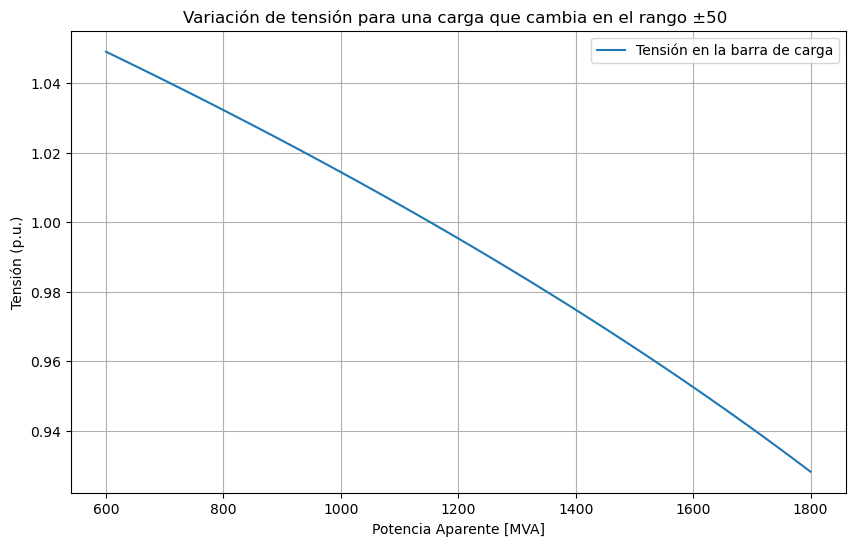

In [12]:
import pandapower as pp
import pandapower.plotting.plotly as plotly
import matplotlib.pyplot as plt
import numpy as np


net = pp.create_empty_network()
bus1 = pp.create_bus(net, name="Barra 1", vn_kv=500, type="b")
bus2 = pp.create_bus(net, name="Barra 2", vn_kv=500, type="b")

# mostrar tabla con barras
print(net.bus)

# Creando un tipo de línea 
linea_a = {"r_ohm_per_km": 0.02, "x_ohm_per_km": 0.115, "c_nf_per_km": 19.1, "max_i_ka": 1}
pp.create_std_type(net, name="linea_a", data=linea_a, element="line")
pp.available_std_types(net, element="line")

# Línea
line1 = pp.create_line(net, from_bus=bus1, to_bus=bus2, length_km=500, std_type="linea_a", name="Línea 1", parallel=2)

print(net.line)


# Añadir una fuente externa
pp.create_ext_grid(net, bus1, vm_pu=1, name="Grid Connection")


#------------Variando la carga------------------ 

# Crear una carga en la barra 2
p_mw_inicial = 1080
q_mvar_inicial = 523.03
pp.create_load(net, bus2, p_mw=p_mw_inicial, q_mvar=q_mvar_inicial, name="Carga")

# Variar la potencia activa y reactiva
p_mw_min = p_mw_inicial * 0.5
p_mw_max = p_mw_inicial * 1.5
q_mvar_min = q_mvar_inicial * 0.5
q_mvar_max = q_mvar_inicial * 1.5
p_mw_range = np.linspace(p_mw_min, p_mw_max, num=100)
q_mvar_range = np.linspace(q_mvar_min, q_mvar_max, num=100)

# Listas para almacenar
potencias_aparentes = []
voltages = []

for p_mw, q_mvar in zip(p_mw_range, q_mvar_range):
    net.load.loc[0, 'p_mw'] = p_mw
    net.load.loc[0, 'q_mvar'] = q_mvar
    pp.runpp(net, max_iteration=2000, tolerance_mva=1*10**(-10))
    # Guardar la tensión en el bus de la carga
    voltages.append(net.res_bus.vm_pu[bus2])
    s_mva = np.sqrt(p_mw**2 + q_mvar**2)
    potencias_aparentes.append(s_mva)


plt.figure(figsize=(10, 6))
plt.plot(potencias_aparentes, voltages, label='Tensión en la barra de carga')
plt.xlabel('Potencia Aparente [MVA]')
plt.ylabel('Tensión (p.u.)')
plt.title('Variación de tensión para una carga que cambia en el rango ±50 ')
plt.legend()
plt.grid(True)
plt.show()

#### Justificación teórica

Es razonable que, a mayor potencia consumida por la carga, mayor sea la caída de tensión, ya que aumenta la demanda de corriente en el sistema.

## 3.b) Compensación

In [42]:
import numpy as np 
from sympy import symbols, Eq, solve
from sympy import solve
import cmath
import sympy as sp
import math

x= sp.symbols('x')
#---------Párametros obtenidos previamente---------
A = 0.97741975+0.00392699999999999j
B = 9.849465+57.080301875j
C = -1.0280886000000084e-06+0.00077948849055j
D = 0.97741975+0.003926999999999999j
#-------------------Datos--------------------------
Sc= 1200*10**6
fp=0.9
Vs= (500*10**3)/np.sqrt(3)
#---------------Formulación----------------------
Vr=Vs
print("VS=",Vs)
Ir= (Sc)/Vr
angulo_grados = math.acos(fp)
Ir_fasor= cmath.rect(Ir,angulo_grados)
print("Ir_fasor=", Ir_fasor)

angulo_y= 90
x=float(x)
x_fasor= cmath.rect(x,90)

print("x=", x_fasor)
print(B*Ir_fasor)

eq= (((B*(x_fasor)+A)*Vr+B*Ir_fasor),Vs)
print(eq)
print(sp.solve(eq,x))
# Resolver la ecuación
soluciones = sp.solve(eq_2, x)
print(soluciones)


VS= 288675.1345948129
Ir_fasor= (3741.229744348775+1811.9602644649797j)


TypeError: Cannot convert expression to float

X= 0.003604[μs]

C= 11[μF]

## 3.c) Pérdidas de línea para rango de pot deman y rango de comp 

### Figura b
<div>
<img src="Figura b.png" width="500"/>
</div>


## 4.a) Identificar líneas saturadas o fuera de norma

### Gráfico Estado líneas

### Método para resolver problema 

## 4.b) Identificar si las Tensiones de las barras estan fuera de norma según ambos escenarios 

### Estado Normal

### Estado Alerta

## 4.c) 

## 4.d)

## 4.e)

## 4.f)

## 4.g)